# Setup

In [ ]:
import time
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm

In [ ]:
def z_normalize(matrix):
    means = matrix.mean(axis=0)
    stds = np.std(matrix, axis=0)
    for i in range(len(stds)):
      if stds[i] == 0.0:
        stds[i] += 1e-10
    return ((matrix - means) / stds), means, stds

In [ ]:
def gradient_descent(data, batch_size, eps_grad, step_updater, w_updater,
                     max_iters=10000, dims=1, step = 1e-3, lam=0.9, init=None):
    
    if not init is None:
      w = init
    else:
      w = np.random.rand(dims + 1)

    square_sum = np.zeros(dims + 1, dtype=np.double)

    streak = 0
    iters = 0
    trace = []
    w_grad = None

    def get_grad(weights, batch):
        grads = np.zeros(dims + 1, dtype=np.double)
        for point in batch:
          xs = np.copy(point)
          label = xs[-1]
          xs[-1] = 1
          y = np.dot(np.array(xs), np.array(weights))

          error = 2 * (y - label)
          grad = np.multiply(xs, error)
          grads = np.add(grads, grad / batch_size)
        return grads

    while streak <= 5 and iters < max_iters:
      if w_grad is None or np.max(np.abs(w_grad)) > eps_grad:
        streak = 0
      else:
        streak += 1
        
      if w_grad is None:
        w_grad = np.zeros(dims+1, dtype=np.double)

      rnd_indices = np.random.choice(len(data), batch_size)
      batch = data[rnd_indices]
      trace.append(w.copy())

      grads = get_grad(w, batch)
        
      step = step_updater(step, iters)
      
      w_grad = w_updater(w, w_grad, grads, lambda weight: get_grad(weight, batch), square_sum)
      w -= w_grad * step
              
      iters += 1

    return w, np.array(trace), iters

In [ ]:
EPS = 1

In [ ]:
def sgd_updater(w, old_grad, new_grad, get_grad, _):
    return new_grad

In [ ]:
def momentum_updater(alpha=0.9):
    return lambda w, old_grad, new_grad, get_grad, _: np.multiply(old_grad, alpha) + np.multiply(new_grad, 1 - alpha)

In [ ]:
def nesterov_updater(alpha=0.2):
    return lambda w, old_grad, new_grad, get_grad, _: np.multiply(old_grad, alpha) + get_grad(w - np.multiply(old_grad, alpha))

In [ ]:
def adagrad_updater(w, old_grad, new_grad, get_grad, square_sum):
  ans = np.divide(new_grad, np.sqrt(np.add(square_sum, EPS)))
  cur_square = np.square(ans)
  square_sum += cur_square
  return ans

In [ ]:
def rms_updater(w, old_grad, new_grad, get_grad, square_sum):
  ans = np.divide(new_grad, np.sqrt(np.add(square_sum, EPS)))
  cur_square = np.square(ans)
  square_sum *= 0.9
  square_sum += cur_square * 0.1  
  return ans

In [ ]:
def adam_ans(w, old_grad, new_grad, get_grad, square_sum, alpha):
  ans = np.divide(np.multiply(old_grad, alpha) + np.multiply(new_grad, 1 - alpha), 
                  np.sqrt(np.add(square_sum, EPS)))
  cur_square = np.square(ans)
  square_sum *= 0.9
  square_sum += cur_square * 0.1  
  return ans

def adam_updater(alpha=0.9):
  return lambda w, old_grad, new_grad, get_grad, square_sum: adam_ans(w, old_grad, new_grad, get_grad, square_sum, alpha)

In [ ]:
def const_step_updater():
    return lambda step, iters: step

In [ ]:
def step_decay_updater(drop, epoch_drop):
    return lambda step, iters: (step * drop if (iters + 1) % epoch_drop == 0 
                                   else step)

In [ ]:
def rand_range_init_func(r):
    return lambda d: (torch.rand(d, dtype=torch.float64) - 0.5) * 2 * r

def zero_init_func():
    return lambda d: torch.zeros(d, dtype=torch.float64)

In [ ]:
def plot_iters(min_param, max_param, param_delta, f, label):
    param_num = int((max_param - min_param) / param_delta)
    params = [min_param + param_delta * i for i in range(0, param_num + 1)]
    params[-1] = max_param

    iters = []
    for param in tqdm(params):
        iters.append(f(param))
    plt.plot(params, iters, label=label)

    best_iters = min(iters)
    best_lr = params[iters.index(best_iters)]

    print("fastest convergence(", best_iters, "iterations) with", "batch size", "=",
          round(best_lr, 4))

# Batches and normalization

In [ ]:
def target_f(xs):
  b0 = 2
  return np.dot(xs, np.array([x for x in range(dim)])) + b0

In [ ]:
dim = 25
samples = 200

lst = []
for i in range(samples):
  xs = np.array(rand_range_init_func(1)(dim))
  y = target_f(xs)
  xs = np.append(xs, y)
  lst.append(xs)

data = np.array(lst)
n_data, means, stds = z_normalize(data)

In [ ]:
N = 20

def explore_batch_sizes(batch_size, data, eps_grad):
  iters_avg = 0
  for i in range(N):
    _, _, its = gradient_descent(data, batch_size, eps_grad, step_decay_updater(0.999, 10), sgd_updater, dims=dim, step=1e-2)
    iters_avg += its
  iters_avg /= N
  return iters_avg

def explore_batch_sizes_for_data(data, eps_grad=8e-1):
  return lambda bs: explore_batch_sizes(bs, data, eps_grad)

In [ ]:
EPS_GRAD = 1e-1
N_EPS_GRAD = EPS_GRAD / np.max(stds)

  0%|          | 0/9 [00:00<?, ?it/s]

fastest convergence( 1144.95 iterations) with batch size = 176


  0%|          | 0/9 [00:00<?, ?it/s]

fastest convergence( 504.6 iterations) with batch size = 201


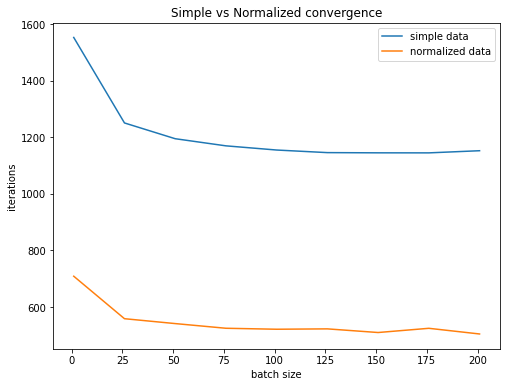

In [ ]:
plt.figure(figsize=(8, 6))
plt.xlabel("batch size")
plt.ylabel("iterations")
plt.title("Simple vs Normalized convergence")
plot_iters(1, samples + 1, 25, explore_batch_sizes_for_data(data, EPS_GRAD), 'simple data')
plot_iters(1, samples + 1, 25, explore_batch_sizes_for_data(n_data, N_EPS_GRAD), 'normalized data')
plt.legend()
plt.show()

In [ ]:
w, trace, its = gradient_descent(data, 1, EPS_GRAD, step_decay_updater(0.999, 10), sgd_updater, dims=dim, step=1e-2)

In [ ]:
for x in range(3):
  test = np.array(data[x])
  test[-1] = 1
  print("{:.2f}".format(np.dot(w, test)) + " and "+ "{:.2f}".format(data[x][-1]))

44.20 and 44.24
-45.74 and -45.67
72.94 and 73.02


In [ ]:

w, trace, its = gradient_descent(n_data, 1, N_EPS_GRAD, step_decay_updater(0.999, 10), sgd_updater, dims=dim, step=1e-2)

In [ ]:
for x in range(3):
  test = np.array(n_data[x])
  test[-1] = 1
  print("{:.2f}".format(np.dot(w, test) * stds[-1] + means[-1]) + " and "+ "{:.2f}".format(data[x][-1]))

44.20 and 44.24
-45.64 and -45.67
73.01 and 73.02


# Setup modifications

In [ ]:
def plotTrace(trace, color, label):
    x_values, y_values = zip(*trace)
    plt.plot(x_values, y_values, '-o', linewidth=1.0, ms=5.0,
             alpha=1.0, label=label, color=color) 

In [ ]:
def plotLevels(func, xrange, yrange):
    x = np.linspace(xrange[0], xrange[1], 100)
    y = np.linspace(yrange[0], yrange[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = float(func(torch.Tensor([X[i, j], Y[i, j]]).double()))

    COLOR_RED = np.linspace(255, 255, 256) / 255.
    COLOR_GREEN = np.linspace(255, 255, 256) / 255.
    COLOR_BLUE = np.linspace(200, 64, 256) / 255.
    colors = np.vstack([COLOR_RED, COLOR_GREEN, COLOR_BLUE]).T
    my_cmap = ListedColormap(colors)
    # my_cmap = plt.cm.Blues

    tmp = np.linspace(0, (np.max(Z) ** (1/6)), 16)
    levels = np.array([x**6 for x in tmp])

    plt.figure(figsize=(14, 14))
    _ = plt.contourf(X, Y, Z, levels=levels, cmap=my_cmap)
    CS = plt.contour(X, Y, Z, levels=levels, colors='black')
    plt.clabel(CS, inline=1, fontsize=8, colors='black')
    plt.grid()

In [ ]:
def process_f(func, data, step_updater, title, dims=1):

    init = np.array([6.0, 12.0])
    coordinates = []

    methods = [
              ("r", "SGD", sgd_updater),
              ("#3FFEE1", "RMSProp", rms_updater),
              ("#FB00FF", "AdaGrad", adagrad_updater),
              ("b", "momentum", momentum_updater()),
              ("g", "nesterov", nesterov_updater()),
              ("pink", "Adam", adam_updater(0.9))
    ]

    traces = []

    for (color, name, grad_updater) in methods:
      _, xs, _ = gradient_descent(data, len(data), EPS_GRAD, step_updater, 
                                      grad_updater, dims=dims, step=4e-1, init=init.copy())
      traces.append((xs[::2], color, name))
      coordinates += list(xs)

    coordinates = np.array(coordinates)
    min_x = coordinates[:, 0].min()
    max_x = coordinates[:, 0].max()
    min_y = coordinates[:, 1].min()
    max_y = coordinates[:, 1].max()
    delta_x = max_x - min_x
    delta_y = max_y - min_y
    plotLevels(func, 
               [min_x - delta_x / 32, max_x + delta_x / 32], 
               [min_y - delta_y / 32, max_y + delta_y / 32])  
    
    for (i, j, k) in traces:
      plotTrace(i, j, k)
    plt.legend()
    plt.xlabel('w1')
    plt.ylabel('b0')
    plt.title(title)
    plt.show()

In [ ]:
def eval_loss(w, data):
  loss = 0.0
  for point in data:
    xs = np.copy(point)
    label = xs[-1]
    xs[-1] = 1
    y = np.dot(np.array(xs), np.array(w))

    loss += (y - label) ** 2
  return loss / len(data)


def loss_f(data):
  return lambda w: eval_loss(w, data)

# Modifications comparison

In [ ]:
methods = [
          ("r", "SGD", sgd_updater),
          ("#3FFEE1", "RMSProp", rms_updater),
          # ("#FB00FF", "AdaGrad", adagrad_updater),
          ("b", "momentum", momentum_updater()),
          ("g", "nesterov", nesterov_updater()),
          ("pink", "Adam", adam_updater(0.9))
          ]

def plot_all_modification(min_param, max_param, param_delta, calc_amount=5):
  param_num = int((max_param - min_param) / param_delta)
  params = [min_param + param_delta * i for i in range(0, param_num + 1)]
  params[-1] = max_param

  iters = [[] for i in range(len(methods))]
  losses = [[] for i in range(len(methods))]
  times = [[] for i in range(len(methods))]
  for param in tqdm(params):
      for i, (_, _, method) in enumerate(methods):
          summ_iter = 0
          summ_loss = 0
          summ_time = 0
          for j in range(calc_amount):
              start = time.time()
              w, _, it = gradient_descent(data, param, EPS_GRAD, const_step_updater(), method, dims=dim, step=4e-2)
              summ_time += (time.time() - start) / calc_amount
              summ_iter += it / calc_amount
              summ_loss += eval_loss(w, data) / calc_amount
          times[i].append(summ_time)
          iters[i].append(summ_iter)
          losses[i].append(summ_loss)
  
  def show_plt(points, y_label, title):
    plt.figure(figsize=(10, 8))
    plt.xlabel("batch size")
    plt.ylabel(y_label)
    plt.title(title)
    for i in range(len(points)):
        plt.plot(params, points[i], label=methods[i][1])
    plt.legend()
    plt.show()

  show_plt(iters, "iterations", "Convergence")
  show_plt(losses, "loss", "Accuracy")
  show_plt(times, "time", "Speed")

  0%|          | 0/13 [00:00<?, ?it/s]

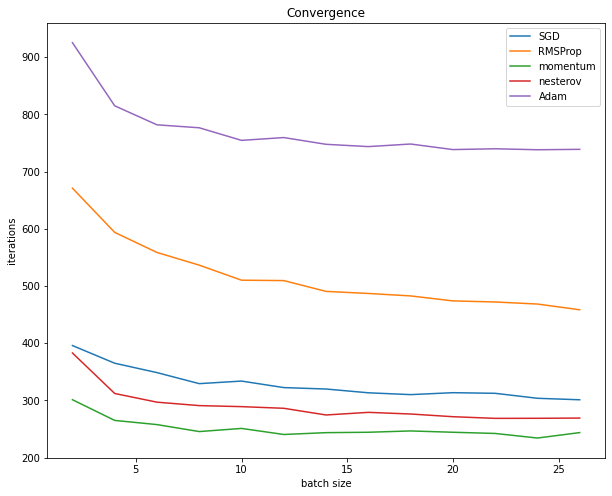

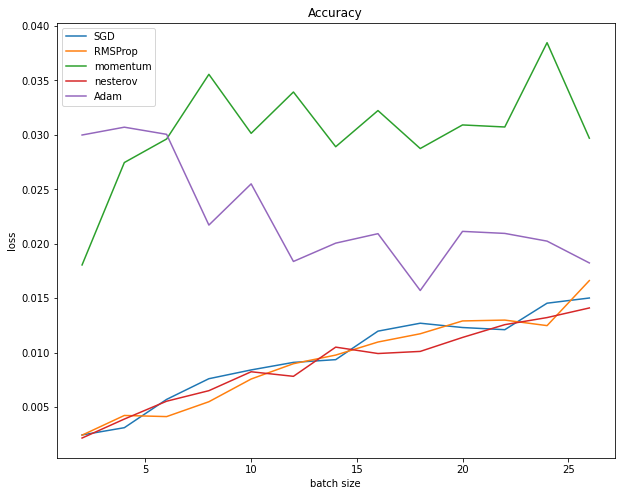

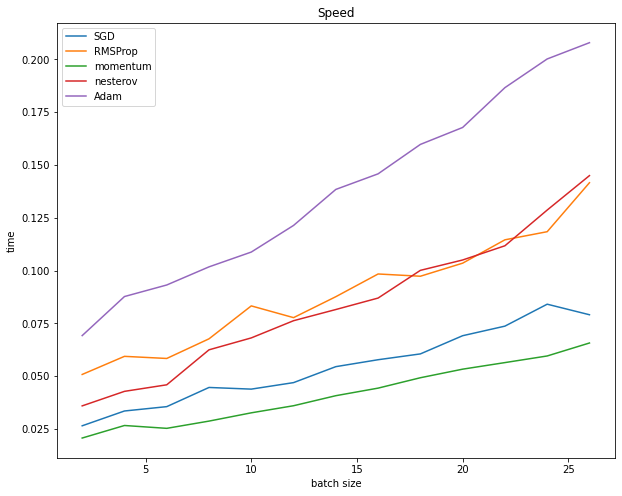

In [ ]:
plot_all_modification(2, 26, 2, calc_amount=10)
# По памяти: Adagrad, RMSProp и Adam используют дополнительный массив из n элементов

# Draw trajectories

In [ ]:
def target_f2(xs):
  b0 = 2
  return np.dot(2 * math.sin(xs[0]), np.array([x + 1 for x in range(dim)])) + b0

In [ ]:
dim = 1
samples = 50

lst = []
for i in range(samples):
  xs = np.array(rand_range_init_func(1)(dim))
  y = target_f2(xs)
  xs = np.append(xs, y)
  lst.append(xs)

data = np.array(lst)

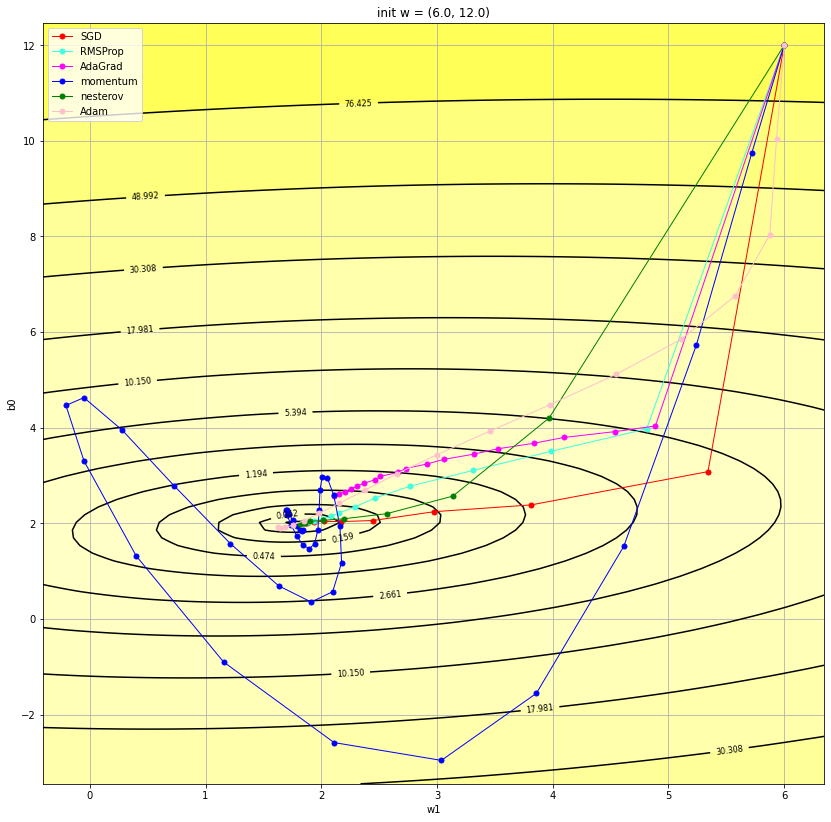

In [ ]:
process_f(loss_f(data), data, const_step_updater(), "init w = (6.0, 12.0)")